Generation 1: Mean Fitness: -1.6176, Sigma: 0.489314
Generation 2: Mean Fitness: -1.7156, Sigma: 0.479359
Generation 3: Mean Fitness: -1.6512, Sigma: 0.496920
Generation 4: Mean Fitness: -1.5396, Sigma: 0.497081
Generation 5: Mean Fitness: -1.8627, Sigma: 0.487109
Generation 6: Mean Fitness: -1.6664, Sigma: 0.471347
Generation 7: Mean Fitness: -1.6127, Sigma: 0.456844
Generation 8: Mean Fitness: -1.5471, Sigma: 0.435429
Generation 9: Mean Fitness: -1.3508, Sigma: 0.425810
Generation 10: Mean Fitness: -1.3969, Sigma: 0.419371
Generation 11: Mean Fitness: -1.4360, Sigma: 0.423560
Generation 12: Mean Fitness: -1.4281, Sigma: 0.414503
Generation 13: Mean Fitness: -1.4587, Sigma: 0.410204
Generation 14: Mean Fitness: -1.3394, Sigma: 0.409673
Generation 15: Mean Fitness: -1.4414, Sigma: 0.404751
Generation 16: Mean Fitness: -1.3887, Sigma: 0.404620
Generation 17: Mean Fitness: -1.3220, Sigma: 0.430514
Generation 18: Mean Fitness: -1.2530, Sigma: 0.437825
Generation 19: Mean Fitness: -1.4786,

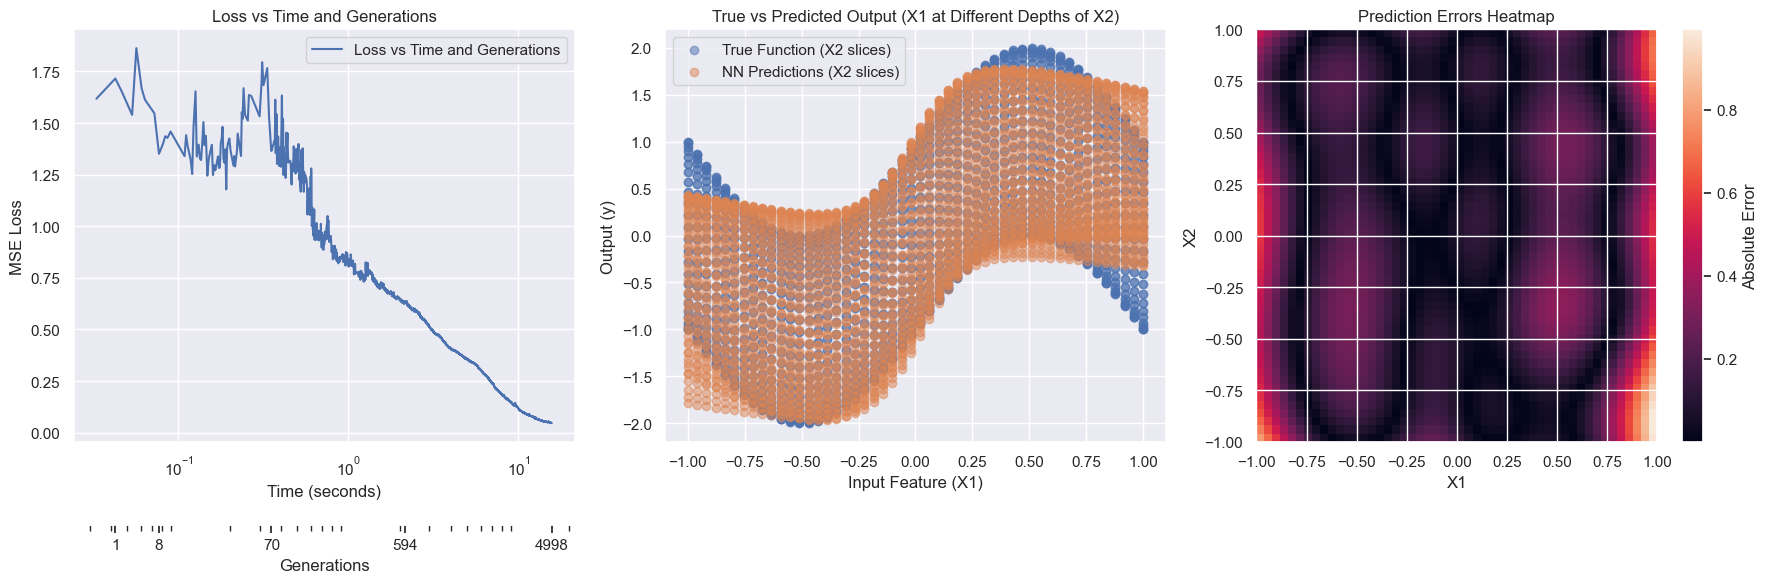

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import time

# Natural Evolution Strategies (NES) Implementation
class NaturalEvolutionStrategy:
    def __init__(self, network, population_size, learning_rate, sigma_init, seed=None):
        self.network = network
        self.population_size = population_size  # Number of candidate solutions
        self.learning_rate = learning_rate  # Learning rate for updates
        self.sigma = sigma_init  # Initial standard deviation (spread) of the Gaussian distribution
        self.mean = self.network.get_parameters()  # Initial parameters of the neural network
        self.dim = len(self.mean)  # Dimensionality of the parameter vector
        self.rng = np.random.default_rng(seed)  # Random number generator for reproducibility

    def fitness_shaping(self, rewards):
        ranks = np.argsort(np.argsort(-rewards))  # Rank rewards in descending order
        utilities = np.maximum(0, np.log(self.population_size / 2 + 1) - np.log(ranks + 1))  # Log-based smoothing
        utilities -= np.mean(utilities) # Normalize utilities so their sum is zero
        return utilities

    def optimize(self, fitness_function, generations, sigma_min=1e-5, sigma_max=10.0):
        self.loss_history = []  # Track loss values over generations
        self.time_history = []  # Track elapsed time for each generation

        start_time = time.time()
        for gen in range(generations):
            samples = self.rng.normal(self.mean, self.sigma, (self.population_size, self.dim))
            fitness = np.array([fitness_function(sample) for sample in samples])
            utilities = self.fitness_shaping(fitness)

            log_derivative_mean = (samples - self.mean) / self.sigma**2  # Gradient wrt mean
            log_derivative_sigma = (np.linalg.norm(samples - self.mean, axis=1)**2 - self.dim) / self.sigma  # Gradient wrt std dev
            grad_mean = np.dot(utilities, log_derivative_mean) / self.population_size
            grad_sigma = np.dot(utilities, log_derivative_sigma) / self.population_size

            fisher = np.dot(log_derivative_mean.T, log_derivative_mean) / self.population_size
            reg_fisher = fisher + np.eye(fisher.shape[0]) * 1e-5

            # Update the mean with Fisher information
            self.mean += self.learning_rate * np.linalg.solve(reg_fisher, grad_mean)

            # Update sigma and apply constraints
            self.sigma *= np.exp(self.learning_rate / 2 * grad_sigma)
            self.sigma = np.clip(self.sigma, sigma_min, sigma_max)  # Cap sigma within [sigma_min, sigma_max]

            # Track loss and elapsed time
            self.loss_history.append(-np.mean(fitness))
            self.time_history.append(time.time() - start_time)
            print(f"Generation {gen+1}: Mean Fitness: {np.mean(fitness):.4f}, Sigma: {self.sigma:.6f}")


    def get_parameters(self):
        return self.mean



# Neural Network with Support for Multiple Layers
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes  # List defining the structure of the network
        self.params = self.initialize_parameters()  # Initialize weights and biases

    def initialize_parameters(self):
        params = []
        for i in range(len(self.layer_sizes) - 1):
            input_size, output_size = self.layer_sizes[i], self.layer_sizes[i + 1]
            params.append(np.random.randn(input_size * output_size) * 0.1)  # Weights
            params.append(np.random.randn(output_size) * 0.1)  # Biases
        return np.concatenate(params)  # Flatten parameters into a single vector

    def get_parameters(self):
        return self.params

    def set_parameters(self, params):
        self.params = params

    def predict(self, X):
        params = self.params
        start = 0
        for i in range(len(self.layer_sizes) - 1):
            input_size, output_size = self.layer_sizes[i], self.layer_sizes[i + 1]
            end_weights = start + input_size * output_size
            end_biases = end_weights + output_size

            weights = params[start:end_weights].reshape(input_size, output_size)
            biases = params[end_weights:end_biases]

            X = np.dot(X, weights) + biases
            if i < len(self.layer_sizes) - 2:  # Apply tanh activation for hidden layers only
                X = np.tanh(X)  # Use tanh
            start = end_biases
        return X

    def evaluate_loss(self, X, y):
        predictions = self.predict(X)
        loss = np.mean((predictions - y) ** 2)
        return loss


# Execution
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import numpy as np

    # Generate toy data
    X = np.random.uniform(-1, 1, (500, 2))  # Inputs: 2 features
    y = np.sin(np.pi * X[:, 0]) + np.cos(np.pi * X[:, 1])  # Target: nonlinear function
    y = y.reshape(-1, 1)  # Reshape to match output shape

    # Initialize the neural network
    network = NeuralNetwork(layer_sizes=[2, 5, 5, 1])  # Single hidden layer example

    # Define fitness function for NES
    def fitness_function(params):
        network.set_parameters(params)
        loss = network.evaluate_loss(X, y)
        return -loss  # NES maximizes fitness, so return negative loss

    # Initialize NES optimizer
    nes = NaturalEvolutionStrategy(network, population_size=50, learning_rate=0.1, sigma_init=0.5, seed=42)

    # Train the neural network using NES
    nes.optimize(fitness_function, generations = 5000)

    # Retrieve optimized parameters
    optimized_params = nes.get_parameters()
    network.set_parameters(optimized_params)

    # Evaluate final loss
    final_loss = network.evaluate_loss(X, y)
    print(f"Final Loss: {final_loss:.4f}")

    # Visualization
    grid_size = 50
    x1 = np.linspace(-1, 1, grid_size)
    x2 = np.linspace(-1, 1, grid_size)
    X1, X2 = np.meshgrid(x1, x2)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    y_true = np.sin(np.pi * X_grid[:, 0]) + np.cos(np.pi * X_grid[:, 1])
    y_pred = network.predict(X_grid).flatten()

    # Create the plots
    fig = plt.figure(figsize=(18, 6))

    # Plot 1: Loss vs Time with Generations (Offset Generations Axis)
    ax1 = fig.add_subplot(131)
    ax1.plot(nes.time_history, nes.loss_history, label='Loss vs Time and Generations')
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("MSE Loss")
    ax1.set_title("Loss vs Time and Generations")
    # Set log scale for the primary x-axis
    ax1.set_xscale("log")

    # Adjust the secondary x-axis (generations)
    ax1_gen = ax1.secondary_xaxis("bottom")
    gen_ticks = np.logspace(0, np.log10(len(nes.loss_history) - 1), 5).astype(int)  # Use log spacing
    time_ticks = [nes.time_history[i] for i in gen_ticks]
    ax1_gen.set_xticks(time_ticks)
    ax1_gen.set_xticklabels(gen_ticks)
    ax1_gen.set_xlabel("Generations")
    ax1_gen.spines["bottom"].set_position(("outward", 60))  # Offset the secondary axis

    ax1.legend()

    # Plot 2: True Sampling Function vs NN Predictions
    ax2 = fig.add_subplot(132)
    ax2.scatter(X_grid[:, 0], y_true, alpha=0.5, label="True Function (X2 slices)")
    ax2.scatter(X_grid[:, 0], y_pred, alpha=0.5, label="NN Predictions (X2 slices)")
    ax2.set_title("True vs Predicted Output (X1 at Different Depths of X2)")
    ax2.set_xlabel("Input Feature (X1)")
    ax2.set_ylabel("Output (y)")
    ax2.legend()

    # Plot 3: Heatmap of Prediction Errors
    errors = np.abs(y_true - y_pred).reshape(grid_size, grid_size)  # Compute absolute errors
    ax3 = fig.add_subplot(133)
    heatmap = ax3.imshow(errors, extent=(-1, 1, -1, 1), origin="lower", aspect="auto")
    plt.colorbar(heatmap, ax=ax3, label="Absolute Error")
    ax3.set_title("Prediction Errors Heatmap")
    ax3.set_xlabel("X1")
    ax3.set_ylabel("X2")

    plt.tight_layout()
    plt.show()

